# **Section 0: Introduction**

---
This notebook contains all the code, runs & results for the GBM environment for the paper "Learning the Greeks".

**To-Do List:**

*   Single Option Case: Structuring the Code.

*   Basket Option Case: 1,5,20,50,100 underlyings. Run and Get Results.

*   Exotic Option Case

**Long Term Goal:**
*   Hyperparameter Sensitivity Analysis








In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Learning the Greeks Paper

/content/gdrive/MyDrive/Learning the Greeks Paper


# **Section 1: Single European Option** #
---
Single European Option Case, RL + GP + MGPRL

## **1.1: RL-ANN Solver**


### **1.1.1: European Call**

#### **Training**

In [ ]:
if not os.path.isdir('GBM/Single Option/RL_ANN/European Call'):
    os.makedirs('GBM/Single Option/RL_ANN/European Call')

In [ ]:
cd /content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Call

/content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Call


START TRAINING
Epoch: 0 Loss: 1.8409802913665771
Epoch: 1 Loss: 1.838895559310913
Epoch: 2 Loss: 1.828825831413269
Epoch: 3 Loss: 0.019769424572587013
Epoch: 4 Loss: 0.01600537821650505
Epoch: 5 Loss: 0.009639847092330456
Epoch: 6 Loss: 0.004505494609475136
Epoch: 7 Loss: 0.0032753609120845795
Epoch: 8 Loss: 0.002094701398164034
Epoch: 9 Loss: 0.0014093221398070455
Epoch: 10 Loss: 0.0009636005270294845
Epoch: 11 Loss: 0.0007121479720808566
Epoch: 12 Loss: 0.0007314107497222722
Epoch: 13 Loss: 0.00039782701060175896
Epoch: 14 Loss: 0.0003899709554389119
Epoch: 15 Loss: 0.00029781810007989407
Epoch: 16 Loss: 0.00024959538131952286
Epoch: 17 Loss: 0.00020757880702149123
Epoch: 18 Loss: 0.0001725304318824783
Epoch: 19 Loss: 0.00015295353659894317
Epoch: 20 Loss: 0.00014217960415408015
Epoch: 21 Loss: 0.00012408230395521969
Epoch: 22 Loss: 0.00012194135342724621
Epoch: 23 Loss: 0.00029813210130669177
Epoch: 24 Loss: 0.00010827760706888512
Epoch: 25 Loss: 0.00014480666141025722
Epoch: 26 Los

No handles with labels found to put in legend.


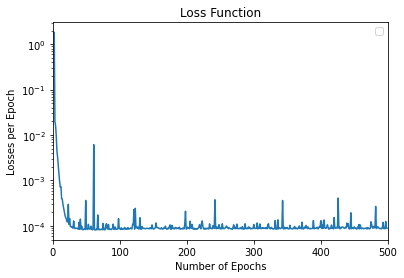

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

np.random.seed(521)
tf.random.set_seed(521)

tf.keras.backend.set_floatx('float64')

directory = '.'

# network for synthetic data
activation = tf.tanh
hidden_layer = [50,50]
n_outputs = 1
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 100000, decay_rate=0.96, staircase=False, name=None)

#input processing
def process_input(X_input, X_input_):
	r = tf.fill([tf.shape(input=X_input)[0],1], np.float64(0.02), name = 'r') # interest rate, if applicable

	S = tf.slice(X_input, (0,0), (-1,1))
	K = tf.slice(X_input, (0,1), (-1,1))
	T = tf.slice(X_input, (0,2), (-1,1))
	
	S_ = tf.slice(X_input_, (0,0), (-1,1))
	T_ = tf.slice(X_input_, (0,1), (-1,1))
	return S, K, T, S_, T_, r

# define neural network architecture
ann = tf.keras.Sequential(
    layers=[tf.keras.layers.Dense(hidden_layer[0], activation = activation, input_shape = (2,))] + \
	[tf.keras.layers.Dense(hidden_layer[i], activation = activation) for i in range(1, len(hidden_layer))] + \
	[tf.keras.layers.Dense(n_outputs, activation = tf.keras.activations.softplus)],
    name="ann")

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# define loss function
hedging_mse = tf.keras.losses.MeanSquaredError()

#evaluate loss function and gradient
@tf.function
def loss(X_input, X_input_):
  S, K, T, S_, T_, r = process_input(X_input, X_input_)
  with tf.GradientTape() as tape:
        tape.watch(S)
        X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN
        X_ = tf.concat([S_/(K*tf.exp(-r*T_)), T_], 1) #input matrix for ANN_

        out = ann(X)
        out = K*tf.where(tf.greater(T, 1e-3), out, tf.maximum(S/K - 1, 0))
        out_ = ann(X_)
        out_ = K*tf.where(tf.greater(T_, 1e-3), out_, tf.maximum(S_/K - 1, 0))
  delta = tape.gradient(out, S)
  delta = tf.maximum(delta,0)
  delta = tf.minimum(delta, 1)
  return hedging_mse(delta*(S_-S), out_-out)

@tf.function
def grad(X_train, X_train_):
	with tf.GradientTape() as tape:
		tape.watch(ann.trainable_variables)
		loss_value = loss(X_train, X_train_)
	return loss_value, tape.gradient(loss_value, ann.trainable_variables)

# define training ops
@tf.function
def training_op(X_train, X_train_):
	loss_value, grads = grad(X_train, X_train_)
	optimizer.apply_gradients(zip(grads, ann.trainable_variables))

# Simulating geometric Brownian motion
def stock_sim_path(S, alpha, delta, sigma, T, N, n):
    """Simulates geometric Brownian motion."""
    h = T/n
    mean = (alpha - delta - .5*sigma**2)*h
    vol = sigma * h**.5
    return S*np.exp((mean + vol*np.random.randn(n,N)).cumsum(axis = 0))

def get_batch2(stock_path,n, moneyness_range = (.5,2)): 
    """Constructs theoretical options based on the time series stock_path"""
    picks = np.random.randint(0, len(stock_path)-1, n)
    T = np.random.randint(1, 150, (n,1))
    S = stock_path[picks]
    S_ = stock_path[picks+1]
    K = np.random.uniform(*moneyness_range, (n,1))*S
    X = np.hstack([S, K, T/250])
    X_ = np.hstack([S_, (T-1)/250])
    return X, X_

#model training
n_epochs = 500  # number of training epochs
n_batches = 1000  # number of batches per epoch
batch_size = 10000 # number of theoretical options in each batch
T = 2 # number of years of training data
days = int(250*T)

stock_path = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path
stock_path_test = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path
# stock_path_test = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path used in original paper
# stock_path_test = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path for cross-validation used in original paper

X_test, X_test_ = get_batch2(stock_path_test, batch_size) #get test-set

#TRAINING
losses = []
count = 0
print("START TRAINING")
for epoch in range(n_epochs):
	for batch in range(n_batches):
		X_train, X_train_ = get_batch2(stock_path, batch_size) # get batch of theoretical options
		training_op(X_train, X_train_)
	epoch_loss = loss(X_test, X_test_)
	losses.append(epoch_loss)
	print('Epoch:', epoch, 'Loss:', epoch_loss.numpy())
	count += 1
ann.save('gbm_single_european_call.h5')

plt.figure()
plt.semilogy(np.arange(count), losses)
plt.legend()
plt.title('Loss Function')
plt.xlabel('Number of Epochs')
plt.ylabel('Losses per Epoch')
plt.xlim([0, count])
plt.savefig('gbm_single_european_call_loss.png')

#### **Results**

In [ ]:
cd /content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Call

/content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Call


In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as si

def bs(S, K, T, r, sigma):
	d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
	d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
	
	call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
	delta = si.norm.cdf(d1)
	theta = - (S * sigma * si.norm.pdf(d1)) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)
	gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T)) 
	charm = - si.norm.pdf(d1) * (2*r*T - d2*sigma*np.sqrt(T)) / (2 * T * sigma * np.sqrt(T))
	return call, delta, theta, gamma, charm

if not os.path.isdir('results'):
    os.makedirs('results')

model = tf.keras.models.load_model('gbm_single_european_call.h5')
print("Model restored.")
model.summary()

#Initialize time list
t = []
for i in range(60,121,15):
	t.append(i/250)

# 3-D cost graph, for various K & T, K is ranging from (90,110), while T ranges from (60,120,10)
for j in range(len(t)):
	T = t[j]
	print("Time to Maturity: ", T)
	K = []
	for i in range(21):
		K.append(i+90)

	if not os.path.isdir('results/TTM: ' + str(T)):
			os.makedirs('results/TTM: ' + str(T))

	X_train = np.ones((10000,3,21))
	for i in range(21):
		X_train[:, 0, i] = np.linspace(75, 125, num=10000)
		X_train[:, 1, i] *= K[i]
		X_train[:, 2, i] *= T
	bs_call = np.ones((10000,21))
	bs_delta = np.ones((10000,21))
	bs_theta = np.ones((10000,21))
	bs_gamma = np.ones((10000,21))
	bs_charm = np.ones((10000,21))

	for i in range(21):
		call, delta, theta, gamma, charm = bs(X_train[:,0,i], K[i], T, 0.02, .125)
		bs_call[:,i] = call
		bs_delta[:,i] = delta
		bs_theta[:,i] = theta
		bs_gamma[:,i] = gamma
		bs_charm[:,i] = charm
	pred_call = np.ones((10000,21))
	pred_delta = np.ones((10000,21))
	pred_theta = np.ones((10000,21))
	pred_gamma = np.ones((10000,21))
	pred_charm = np.ones((10000,21))

	# Evaluation	
	for i in range(21):
		r = tf.fill([tf.shape(input=X_train)[0],1], np.float64(0.02), name = 'r') # interest rate, if applicable
		S = tf.slice(X_train[:,:,i], (0,0), (-1,1))
		K = tf.slice(X_train[:,:,i], (0,1), (-1,1))
		T = tf.slice(X_train[:,:,i], (0,2), (-1,1))
		with tf.GradientTape() as tape1:
			tape1.watch([S,T])
			with tf.GradientTape() as tape2:
					tape2.watch([S,T])
					X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN

					out = model(X)
					out_values = K*tf.where(tf.greater(T, 1e-3), out, tf.maximum(S/K - 1, 0))
			delta_values, theta_values = tape2.gradient(out_values, [S,T])
		gamma_values, charm_values = tape1.gradient(delta_values, [S,T])

		out_values = out_values.numpy()
		delta_values = delta_values.numpy()
		theta_values = - theta_values
		theta_values = theta_values.numpy()
		gamma_values = gamma_values.numpy()
		charm_values = - charm_values
		charm_values = charm_values.numpy()
		pred_call[:,i] = out_values.reshape(10000,)
		pred_delta[:,i] = delta_values.reshape(10000,)
		pred_theta[:,i] = theta_values.reshape(10000,)
		pred_gamma[:,i] = gamma_values.reshape(10000,)
		pred_charm[:,i] = charm_values.reshape(10000,)
		
	stock_price= X_train[:, 0, :].reshape(10000,21)
	strike_price= X_train[:, 1, :].reshape(10000,21)

	# Results
	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_call, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_call, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('C')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Price.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_delta, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_delta, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Delta')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Delta.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_theta, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_theta, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Theta')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Theta.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_gamma, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_gamma, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Gamma')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_charm, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_charm, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Charm')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Charm.png')
 
	# Error of Results
	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_call-pred_call, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Call Price')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Error.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_delta-pred_delta, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Delta Value')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Delta_Error.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_theta-pred_theta, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Theta Value')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Theta_Error.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_gamma-pred_gamma, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Gamma Value')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma_Error.png')

	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_charm-pred_charm, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Charm Value')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Charm_Error.png')

Output hidden; open in https://colab.research.google.com to view.

### **1.1.2: European Put**

#### **Training**

In [ ]:
if not os.path.isdir('GBM/Single Option/RL_ANN/European Put'):
    os.makedirs('GBM/Single Option/RL_ANN/European Put')

In [ ]:
cd /content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Put

/content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Put


START TRAINING
Epoch: 0 Loss: 0.12718737125396729
Epoch: 1 Loss: 0.11355353146791458
Epoch: 2 Loss: 0.04107927903532982
Epoch: 3 Loss: 0.011206935159862041
Epoch: 4 Loss: 0.009931578300893307
Epoch: 5 Loss: 0.006443309132009745
Epoch: 6 Loss: 0.00700814975425601
Epoch: 7 Loss: 0.005264952778816223
Epoch: 8 Loss: 0.004733426496386528
Epoch: 9 Loss: 0.004431684501469135
Epoch: 10 Loss: 0.004843955393880606
Epoch: 11 Loss: 0.00366606586612761
Epoch: 12 Loss: 0.0034650173038244247
Epoch: 13 Loss: 0.0022402245085686445
Epoch: 14 Loss: 0.0014358102343976498
Epoch: 15 Loss: 0.000944945786613971
Epoch: 16 Loss: 0.0007151651661843061
Epoch: 17 Loss: 0.0022438103333115578
Epoch: 18 Loss: 0.0011853764299303293
Epoch: 19 Loss: 0.0006813069339841604
Epoch: 20 Loss: 0.0005223757470957935
Epoch: 21 Loss: 0.0005246935179457068
Epoch: 22 Loss: 0.0005426874849945307
Epoch: 23 Loss: 0.00043625340913422406
Epoch: 24 Loss: 0.0003885572368744761
Epoch: 25 Loss: 0.00042355552432127297
Epoch: 26 Loss: 0.00037

No handles with labels found to put in legend.


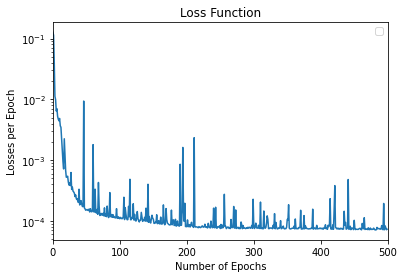

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

np.random.seed(921)
tf.random.set_seed(921)

tf.keras.backend.set_floatx('float64')

directory = '.'

# network for synthetic data
activation = tf.tanh
hidden_layer = [50,50]
n_outputs = 1
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 100000, decay_rate=0.96, staircase=False, name=None)

#input processing
def process_input(X_input, X_input_):
	r = tf.fill([tf.shape(input=X_input)[0],1], np.float64(0.02), name = 'r') # interest rate, if applicable

	S = tf.slice(X_input, (0,0), (-1,1))
	K = tf.slice(X_input, (0,1), (-1,1))
	T = tf.slice(X_input, (0,2), (-1,1))
	
	S_ = tf.slice(X_input_, (0,0), (-1,1))
	T_ = tf.slice(X_input_, (0,1), (-1,1))
	return S, K, T, S_, T_, r

# define neural network architecture
ann = tf.keras.Sequential(
    layers=[tf.keras.layers.Dense(hidden_layer[0], activation = activation, input_shape = (2,))] + \
	[tf.keras.layers.Dense(hidden_layer[i], activation = activation) for i in range(1, len(hidden_layer))] + \
	[tf.keras.layers.Dense(n_outputs, activation = tf.keras.activations.softplus)],
    name="ann")

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# define loss function
hedging_mse = tf.keras.losses.MeanSquaredError()

#evaluate loss function and gradient
@tf.function
def loss(X_input, X_input_):
  S, K, T, S_, T_, r = process_input(X_input, X_input_)
  with tf.GradientTape() as tape:
        tape.watch(S)
        X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN
        X_ = tf.concat([S_/(K*tf.exp(-r*T_)), T_], 1) #input matrix for ANN_

        out = ann(X)
        out = K*tf.where(tf.greater(T, 1e-3), out, tf.maximum(1 - S/K, 0))
        out_ = ann(X_)
        out_ = K*tf.where(tf.greater(T_, 1e-3), out_, tf.maximum(1 - S_/K, 0))
  delta = tape.gradient(out, S)
  delta = tf.maximum(delta, -1)
  delta = tf.minimum(delta, 0)
  return hedging_mse(delta*(S_-S), out_-out)

@tf.function
def grad(X_train, X_train_):
	with tf.GradientTape() as tape:
		tape.watch(ann.trainable_variables)
		loss_value = loss(X_train, X_train_)
	return loss_value, tape.gradient(loss_value, ann.trainable_variables)

# define training ops
@tf.function
def training_op(X_train, X_train_):
	loss_value, grads = grad(X_train, X_train_)
	optimizer.apply_gradients(zip(grads, ann.trainable_variables))

# Simulating geometric Brownian motion
def stock_sim_path(S, alpha, delta, sigma, T, N, n):
    """Simulates geometric Brownian motion."""
    h = T/n
    mean = (alpha - delta - .5*sigma**2)*h
    vol = sigma * h**.5
    return S*np.exp((mean + vol*np.random.randn(n,N)).cumsum(axis = 0))

def get_batch2(stock_path,n, moneyness_range = (.5,2)): 
    """Constructs theoretical options based on the time series stock_path"""
    picks = np.random.randint(0, len(stock_path)-1, n)
    T = np.random.randint(1, 150, (n,1))
    S = stock_path[picks]
    S_ = stock_path[picks+1]
    K = np.random.uniform(*moneyness_range, (n,1))*S
    X = np.hstack([S, K, T/250])
    X_ = np.hstack([S_, (T-1)/250])
    return X, X_

#model training
n_epochs = 500 #number of training epochs
n_batches = 1000 #number of batches per epoch
batch_size = 10000 #number of theoretical options in each batch
T = 2 # number of years of training data
days = int(250*T)

stock_path = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path
stock_path_test = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path
# stock_path_test = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path used in original paper
# stock_path_test = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path for cross-validation used in original paper

X_test, X_test_ = get_batch2(stock_path_test, batch_size) #get test-set

#TRAINING
losses = []
count = 0
print("START TRAINING")
for epoch in range(n_epochs):
	for batch in range(n_batches):
		X_train, X_train_ = get_batch2(stock_path, batch_size) # get batch of theoretical options
		training_op(X_train, X_train_)
	epoch_loss = loss(X_test, X_test_)
	losses.append(epoch_loss)
	print('Epoch:', epoch, 'Loss:', epoch_loss.numpy())
	count += 1

ann.save('gbm_single_european_put.h5')
plt.figure()
plt.semilogy(np.arange(count), losses)
plt.legend()
plt.title('Loss Function')
plt.xlabel('Number of Epochs')
plt.ylabel('Losses per Epoch')
plt.xlim([0, count])
plt.savefig('gbm_single_european_put_loss.png')

#### **Results**

In [ ]:
cd /content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Put

/content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/RL_ANN/European Put


In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as si

def bs(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    delta = -si.norm.cdf(-d1)
    theta = - (S * sigma * si.norm.pdf(d1)) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2)   
    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    charm = - si.norm.pdf(d1) * (2*r*T - d2*sigma*np.sqrt(T)) / (2 * T * sigma * np.sqrt(T))
    return put, delta, theta, gamma, charm

if not os.path.isdir('results'):
    os.makedirs('results')

model = tf.keras.models.load_model('gbm_single_european_put.h5')
print("Model restored.")
model.summary()

#Initialize time list
t = []
for i in range(60,121,15):
	t.append(i/250)

# 3-D cost graph, for various K & T, K is ranging from (90,110), while T ranges from (60,120,10)
for j in range(len(t)):
  T = t[j]
  print("Time to Maturity: ", T)
  K = []
  for i in range(21):
    K.append(i+90)
  if not os.path.isdir('results/TTM: ' + str(T)):
    os.makedirs('results/TTM: ' + str(T))
  X_train = np.ones((10000,3,21))
  for i in range(21):
    X_train[:, 0, i] = np.linspace(75, 125, num=10000)
    X_train[:, 1, i] *= K[i]
    X_train[:, 2, i] *= T
  bs_put = np.ones((10000,21))
  bs_delta = np.ones((10000,21))
  bs_theta = np.ones((10000,21))
  bs_gamma = np.ones((10000,21))
  bs_charm = np.ones((10000,21))
  for i in range(21):
    put, delta, theta, gamma, charm = bs(X_train[:,0,i], K[i], T, 0.02, .125)
    bs_put[:,i] = put
    bs_delta[:,i] = delta
    bs_theta[:,i] = theta
    bs_gamma[:,i] = gamma
    bs_charm[:,i] = charm
  pred_put = np.ones((10000,21))
  pred_delta = np.ones((10000,21))
  pred_theta = np.ones((10000,21))
  pred_gamma = np.ones((10000,21))
  pred_charm = np.ones((10000,21))
  # Evaluation	
  for i in range(21):
    r = tf.fill([tf.shape(input=X_train)[0],1], np.float64(0.02), name = 'r') # interest rate, if applicable
    S = tf.slice(X_train[:,:,i], (0,0), (-1,1))
    K = tf.slice(X_train[:,:,i], (0,1), (-1,1))
    T = tf.slice(X_train[:,:,i], (0,2), (-1,1))
    with tf.GradientTape() as tape1:
        tape1.watch([S,T])
        with tf.GradientTape() as tape2:
            tape2.watch([S,T])
            X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN

            out = model(X)
            out_values = K*tf.where(tf.greater(T, 1e-3), out, tf.maximum(1 - S/K, 0))
        delta_values, theta_values = tape2.gradient(out_values, [S,T])
    gamma_values, charm_values = tape1.gradient(delta_values, [S,T])

    out_values = out_values.numpy()
    delta_values = delta_values.numpy()
    theta_values = - theta_values
    theta_values = theta_values.numpy()
    gamma_values = gamma_values.numpy()
    charm_values = - charm_values
    charm_values = charm_values.numpy()
    pred_put[:,i] = out_values.reshape(10000,)
    pred_delta[:,i] = delta_values.reshape(10000,)
    pred_theta[:,i] = theta_values.reshape(10000,)
    pred_gamma[:,i] = gamma_values.reshape(10000,)
    pred_charm[:,i] = charm_values.reshape(10000,)

    stock_price= X_train[:, 0, :].reshape(10000,21)
    strike_price= X_train[:, 1, :].reshape(10000,21)
  # Results
  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, pred_put, color='red', label='RL_ANN' )
  ax.plot_wireframe(stock_price, strike_price, bs_put, color='green', label = 'BS')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('P')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Put_Price.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, pred_delta, color='red', label='RL_ANN' )
  ax.plot_wireframe(stock_price, strike_price, bs_delta, color='green', label = 'BS')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Delta')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Delta.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 45
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, pred_theta, color='red', label='RL_ANN' )
  ax.plot_wireframe(stock_price, strike_price, bs_theta, color='green', label = 'BS')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Theta')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Theta.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, pred_gamma, color='red', label='RL_ANN' )
  ax.plot_wireframe(stock_price, strike_price, bs_gamma, color='green', label = 'BS')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Gamma')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, pred_charm, color='red', label='RL_ANN' )
  ax.plot_wireframe(stock_price, strike_price, bs_charm, color='green', label = 'BS')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Charm')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Charm.png')

  # Error of Results
  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 45
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, bs_put-pred_put, color='black', label = 'Error')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Error of Put Price')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Put_Error.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, bs_delta-pred_delta, color='black', label = 'Error')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Error of Delta Value')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Delta_Error.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 45
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, bs_theta-pred_theta, color='black', label = 'Error')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Error of Theta Value')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Theta_Error.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, bs_gamma-pred_gamma, color='black', label = 'Error')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Error of Gamma Value')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma_Error.png')

  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price, strike_price, bs_charm-pred_charm, color='black', label = 'Error')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Error of Charm Value')
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Charm_Error.png')

Output hidden; open in https://colab.research.google.com to view.

## **1.2: GPR Solver**

In [ ]:
!apt install libgsl-dev 
!pip install git+https://github.com/junyanxu/Python-Heston-Option-Pricer.git
!pip install gpflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgsl23 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libgsl-dev libgsl23 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,926 kB of archives.
After this operation, 9,474 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgslcblas0 amd64 2.4+dfsg-6 [79.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl23 amd64 2.4+dfsg-6 [823 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl-dev amd64 2.4+dfsg-6 [1,023 kB]
Fetched 1,926 kB in 0s (15.6 MB/s)
Selecting previously unselected

In [ ]:
import numpy as np
import scipy as sp
import PyHeston 

import tensorflow as tf
import tensorflow_probability as tfp
import gpflow

import scipy.stats as st
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import warnings 
warnings.filterwarnings('once')
# sklearn
import sklearn
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable

import scipy.stats as si
# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
def bsformula(cp, s, k, rf, t, v, div):
    """ Price an option using the Black-Scholes model.
    cp: +1/-1 for call/put
    s: initial stock price
    k: strike price
    t: expiration time
    v: volatility
    rf: risk-free rate
    div: dividend
    """

    d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t)) 
    d2 = d1 - v*np.sqrt(t)

    optprice = (cp*s*np.exp(-div*t)*st.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*st.norm.cdf(cp*d2))
    delta = cp*st.norm.cdf(cp*d1)
    theta = - np.exp(-div*t)*(s * v * st.norm.pdf(d1)) / (2 * np.sqrt(t)) - cp * rf * k * np.exp(-rf * t) * st.norm.cdf(cp * d2) + cp* div*s*np.exp(-div*t)*st.norm.cdf(cp*d1)
    gamma = st.norm.pdf(d1) / (s * v * np.sqrt(t)) 
    charm = cp * div * np.exp(-div*t) * st.norm.cdf(cp*d1) - np.exp(-div*t) * st.norm.pdf(d1) * (2*(rf-div)*t - d2*v*np.sqrt(t)) / (2 * t * v * np.sqrt(t))
    return optprice, delta, theta, gamma, charm

In [ ]:
# Black-Scholes model parameters
r = 0.02  # risk-free rate
S= 100      # Underlying spot
KC = 100    # Call strike
KP = 100   # Put strike
sigma = 0.125 # implied volatility
T = 90/250    # Time to maturity
div = 0       # dividend

### **1.2.1: European Call**

In [ ]:
if not os.path.isdir('GBM/Single Option/GP/European Call'):
    os.makedirs('GBM/Single Option/GP/European Call')

In [ ]:
cd /content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/GP/European Call

/content/gdrive/MyDrive/Learning the Greeks Paper/GBM/Single Option/GP/European Call


In [ ]:
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
delta = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[1]
theta = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[2]
gamma = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[3]
charm = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[4]

#### **Option Prices**

In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as si

if not os.path.isdir('results'):
    os.makedirs('results')

np.random.seed(458)
tf.random.set_seed(458)

#Initialize time list
t = []
for i in range(60,121,15):
	t.append(i/250)

# 3-D cost graph, for various K & T, K is ranging from (90,110), while T ranges from (60,120,15)
for j in range(len(t)):
  T = t[j]
  print("Time to Maturity: ", T)
  K = []
  for i in range(21):
    K.append(i+90)

  if not os.path.isdir('results/TTM: ' + str(T)):
      os.makedirs('results/TTM: ' + str(T))

  X_test = np.ones((10000,3,21))
  for i in range(21):
    X_test[:, 0, i] = np.array(np.linspace(0,1, 10000), dtype='float32')
    X_test[:, 1, i] *= K[i]
    X_test[:, 2, i] *= T

  bs_call = np.ones((10000,21))
  for i in range(21):
    KC = K[i]
    bs_call[:,i] = call(X_test[:,0,i]) 

  pred_call = np.ones((10000,21))
  pred_sigma = np.ones((10000,21))

  # Training & Evaluation	
  for i in range(21):
        KC = K[i]
        lb = 0.001         # lower bound on domain
        ub = 300             # upper bound on domain
        training_number = 1000  # Number of training samples
        testing_number = 10000 # Number of testing samples

        train_x_1 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
        train_y_1 = []
        for S in train_x_1:
            train_y_1.append(call(S))
        
        test_x_1 = X_test[:, 0, i]
        test_y_1 = []
        for S in test_x_1:
            test_y_1.append(call(S))
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(train_x_1,train_y_1)

        y_pred_1, sigma_1 = gp.predict(test_x_1.reshape(-1, 1), return_std=True)

        pred_call[:,i] = y_pred_1.reshape(10000,)
        pred_sigma[:,i] = sigma_1.reshape(10000,)

  stock_price= lb+(ub-lb)*X_test[:, 0, :].reshape(10000,21)
  strike_price= X_test[:, 1, :].reshape(10000,21)

  # Results
  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price[2500:4167,:], strike_price[2500:4167,:], pred_call[2500:4167,:], color='red', label='GP' )
  ax.plot_wireframe(stock_price[2500:4167,:], strike_price[2500:4167,:], bs_call[2500:4167,:], color='green', label = 'BS')
  ax.plot_wireframe(stock_price[2500:4167,:], strike_price[2500:4167,:], (pred_call-2*pred_sigma)[2500:4167,:], color='purple', label='GP Lower Bound')
  ax.plot_wireframe(stock_price[2500:4167,:], strike_price[2500:4167,:], (pred_call+2*pred_sigma)[2500:4167,:], color='blue', label='GP Upper Bound')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('C')
  ax.set_xlim(75,125)
  ax.set_zlim(0,35)
  ax.set_ylim(90,110)
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Price.png')

  # Error of Results
  plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = plt.axes(projection='3d')

  angle = 225
  ax.view_init(37.5, angle)
  ax.plot_wireframe(stock_price[2500:4167,:], strike_price[2500:4167,:], (bs_call-pred_call)[2500:4167,:], color='black', label = 'Error')
  ax.set_xlabel('S')
  ax.set_ylabel('K')
  ax.set_zlabel('Error of Call Price')
  ax.set_xlim(75,125)
  ax.set_zlim(0,35)
  ax.set_ylim(90,110)
  ax.legend(loc = 'best', prop={'size':10})
  plt.show()
  plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Error.png')

Output hidden; open in https://colab.research.google.com to view.

#### **Greeks**

In [ ]:
from random import Random
from numpy import *
from time import *
from datetime import *
import math
import scipy as sp

import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
lb = 0
ub = 300
S0 = 100
training_number = 100
testing_number = 100
sigma_n = 1e-8 # additive noise in GP

In [ ]:
# Delta
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx]))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime_delta = np.dot(k_s_prime, alpha_p)/(ub-lb)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:6: DeprecationWarning: invalid escape sequence \D
<ipython-input-98-53d2e7c73aab>:6: DeprecationWarning: invalid escape sequence \D
  plt.ylabel('$\Delta$')


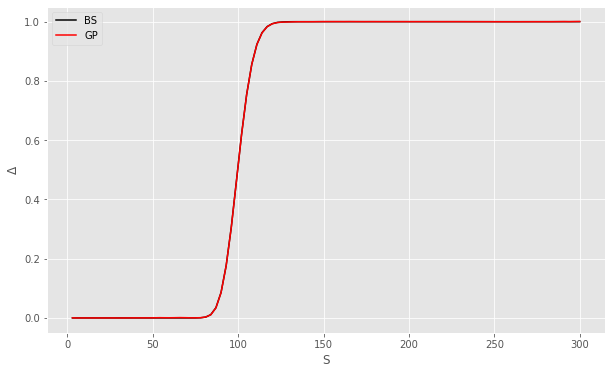

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test), color = 'black', label = 'BS')
plt.plot(lb+(ub-lb)*x_test, f_prime_delta, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10})

In [ ]:
# Theta
call = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, y, sigma, 0)[0]
x_train = np.array(np.linspace(0.01,2.0, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,2.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train))
y_train = np.array(y_train)[0]

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime_theta = np.dot(k_s_prime, alpha_p)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
theta = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, y, sigma, 0)[2]

<input>:6: DeprecationWarning: invalid escape sequence \T
<input>:6: DeprecationWarning: invalid escape sequence \T
<ipython-input-115-47d63db319c3>:6: DeprecationWarning: invalid escape sequence \T
  plt.ylabel('$\Theta$')


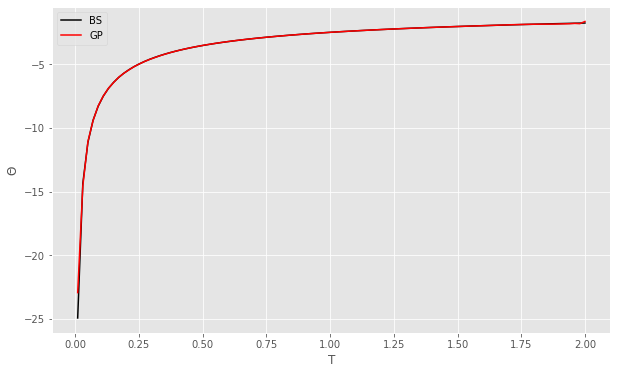

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, theta((S0-lb)/(ub-lb), x_test), color = 'black', label = 'BS')
plt.plot(x_test, -f_prime_theta, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('T')
plt.ylabel('$\Theta$')
plt.legend(loc = 'best', prop={'size':10})

In [ ]:
# Gamma
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    # y_train.append(delta(x_train[idx]))
    y_train.append(f_prime_delta[idx])
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime_gamma = np.dot(k_s_prime, alpha_p)/(ub-lb)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


<input>:6: DeprecationWarning: invalid escape sequence \G
<input>:6: DeprecationWarning: invalid escape sequence \G
<ipython-input-100-f0c1dab29df6>:6: DeprecationWarning: invalid escape sequence \G
  plt.ylabel('$\Gamma$')


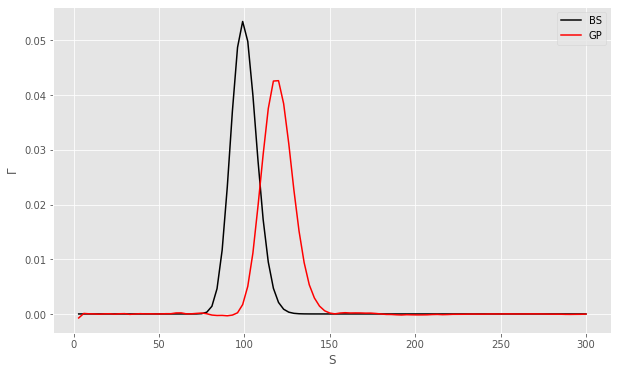

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, gamma(x_test), color = 'black', label = 'BS')
plt.plot(lb+(ub-lb)*x_test, f_prime_gamma, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Gamma$')
plt.legend(loc = 'best', prop={'size':10})

In [ ]:
# Charm
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(theta((S0-lb)/(ub-lb), x_train))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime_charm = np.dot(k_s_prime, alpha_p)/(ub-lb)

ValueError: ignored

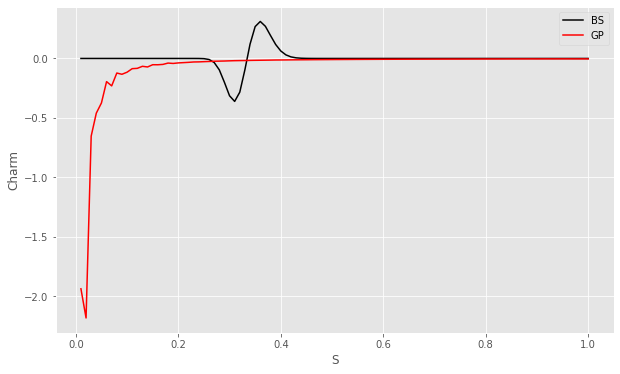

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, charm(x_test), color = 'black', label = 'BS')
plt.plot(x_test, f_prime_charm, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('Charm')
plt.legend(loc = 'best', prop={'size':10})

## **1.3: MGPR Solver**

In [ ]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import torch
import gpytorch
import numpy as np
from scipy import *
from matplotlib import pyplot as plt
from scipy import stats  

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
delta = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[1]
theta = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[2]
gamma = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[3]
charm = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[4]
speed = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[5]
color = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[6]

In [ ]:
# Black-Scholes model parameters
r = 0.0000  # risk-free rate
S= 100      # Underlying spot
KC = 100    # Call strike
KP = 100   # Put strike
sigma = 0.125 # implied volatility
T = 90/250    # Time to maturity
div = 0       # dividend

In [ ]:
lb = 75.001             # lower bound on domain
ub = 125               # upper bound on domain
training_number = 100   # Number of training samples
testing_number = 200  # Number of testing samples

# train_x = torch.linspace(0, 1.0, training_number)
# train_y1 = torch.FloatTensor(call(np.array(train_x)))
# train_y2 = torch.FloatTensor(delta(np.array(train_x)))
# train_y3 = torch.FloatTensor(theta(np.array(train_x)))
# train_y4 = torch.FloatTensor(gamma(np.array(train_x)))
# train_y5 = torch.FloatTensor(charm(np.array(train_x)))
# train_y6 = torch.FloatTensor(speed(np.array(train_x)))
# train_y7 = torch.FloatTensor(color(np.array(train_x)))

train_x = torch.linspace(0, 1.0, training_number)
train_y1 = torch.FloatTensor(pred_call[::100,1])
train_y2 = torch.FloatTensor(pred_delta[::100,1])
train_y3 = torch.FloatTensor(pred_theta[::100,1])
train_y4 = torch.FloatTensor(pred_gamma[::100,1])
train_y5 = torch.FloatTensor(pred_charm[::100,1])
train_y6 = torch.FloatTensor(pred_speed[::100,1])
train_y7 = torch.FloatTensor(pred_color[::100,1])

#Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2, train_y3, train_y4, train_y5, train_y6, train_y7], -1)

In [ ]:
min(pred_theta[:,1])

-2.964574634986057

In [ ]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=7
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)), num_tasks=7, rank=1
        )
              
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [ ]:
# test_x = torch.linspace(0, 1.0, testing_number)
# test_y1 = torch.FloatTensor(call(np.array(test_x)))
# test_y2 = torch.FloatTensor(delta(np.array(test_x)))
# test_y3 = torch.FloatTensor(theta(np.array(test_x)))
# test_y4 = torch.FloatTensor(gamma(np.array(test_x)))
# test_y5 = torch.FloatTensor(charm(np.array(test_x)))
# test_y6 = torch.FloatTensor(speed(np.array(test_x)))
# test_y7 = torch.FloatTensor(color(np.array(test_x)))

test_x = torch.linspace(0, 1.0, testing_number)
test_y1 = torch.FloatTensor(pred_call[::50,1])
test_y2 = torch.FloatTensor(pred_delta[::50,1])
test_y3 = torch.FloatTensor(pred_theta[::50,1])
test_y4 = torch.FloatTensor(pred_gamma[::50,1])
test_y5 = torch.FloatTensor(pred_charm[::50,1])
test_y6 = torch.FloatTensor(pred_speed[::50,1])
test_y7 = torch.FloatTensor(pred_color[::50,1])
test_y = torch.stack([test_y1, test_y2, test_y4, test_y5, test_y6, test_y7], -1)

In [ ]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.lengthscale, likelihood.noise))
    
    optimizer.step()

Iter 1/100 - Loss: 1.867 lengthscale: 0.693 noise: 0.693
Iter 2/100 - Loss: 1.725 lengthscale: 0.644 noise: 0.644
Iter 3/100 - Loss: 1.601 lengthscale: 0.599 noise: 0.598
Iter 4/100 - Loss: 1.492 lengthscale: 0.556 noise: 0.554
Iter 5/100 - Loss: 1.396 lengthscale: 0.517 noise: 0.513
Iter 6/100 - Loss: 1.311 lengthscale: 0.482 noise: 0.473
Iter 7/100 - Loss: 1.233 lengthscale: 0.451 noise: 0.436
Iter 8/100 - Loss: 1.162 lengthscale: 0.423 noise: 0.402
Iter 9/100 - Loss: 1.095 lengthscale: 0.398 noise: 0.369
Iter 10/100 - Loss: 1.032 lengthscale: 0.376 noise: 0.339
Iter 11/100 - Loss: 0.971 lengthscale: 0.358 noise: 0.310
Iter 12/100 - Loss: 0.913 lengthscale: 0.342 noise: 0.284
Iter 13/100 - Loss: 0.857 lengthscale: 0.329 noise: 0.259
Iter 14/100 - Loss: 0.803 lengthscale: 0.318 noise: 0.237
Iter 15/100 - Loss: 0.749 lengthscale: 0.308 noise: 0.216
Iter 16/100 - Loss: 0.696 lengthscale: 0.301 noise: 0.196
Iter 17/100 - Loss: 0.643 lengthscale: 0.296 noise: 0.178
Iter 18/100 - Loss: 0.5

In [ ]:
# Make predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat= likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


In [ ]:
# Print fitted parameters
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
#lengthscale=model.covar_module.data_covar_module.lengthscale
lengthscale = model.covar_module.data_covar_module.base_kernel.lengthscale
sigma_2_n = likelihood.noise
nu = model.covar_module.data_covar_module.base_kernel.nu
print(lengthscale, sigma_2_n, nu, Omega)

tensor([[0.5064]], grad_fn=<SoftplusBackward0>) tensor([0.0002], grad_fn=<AddBackward0>) 2.5 [[ 2.4271263e+01  3.6532041e-01  2.9127619e+00 -1.6036004e-02
   9.1893017e-02 -3.2169940e-03  2.1507686e-01]
 [ 3.6532041e-01  5.5556498e-02  5.1189713e-02 -2.8182133e-04
   1.6149542e-03 -5.6536373e-05  3.7798223e-03]
 [ 2.9127619e+00  5.1189713e-02  5.3844676e+00 -2.2470094e-03
   1.2876305e-02 -4.5077415e-04  3.0137166e-02]
 [-1.6036004e-02 -2.8182133e-04 -2.2470094e-03  1.1318775e-03
  -7.0889582e-05  2.4817050e-06 -1.6591803e-04]
 [ 9.1893017e-02  1.6149542e-03  1.2876305e-02 -7.0889582e-05
   9.0014213e-01 -1.4221209e-05  9.5077982e-04]
 [-3.2169940e-03 -5.6536373e-05 -4.5077415e-04  2.4817050e-06
  -1.4221209e-05  3.6334546e-04 -3.3284934e-05]
 [ 2.1507686e-01  3.7798223e-03  3.0137166e-02 -1.6591803e-04
   9.5077982e-04 -3.3284934e-05  8.4358230e-02]]


In [ ]:
upper[:,0].detach().numpy()

array([ 0.03517404,  0.0353128 ,  0.03531828, ..., 33.35341   ,
       33.358185  , 33.36293   ], dtype=float32)

Text(0, 0.5, 'Color')

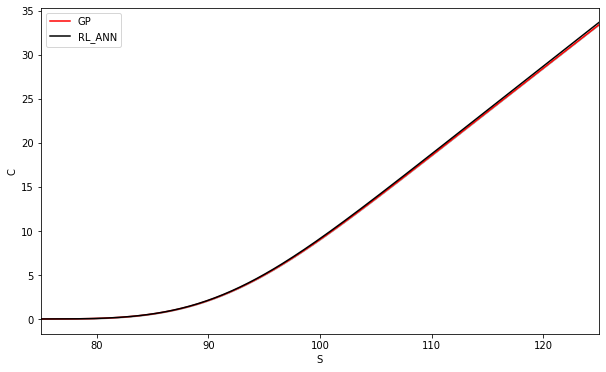

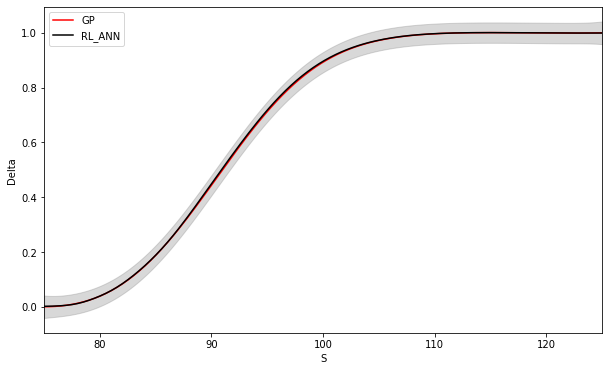

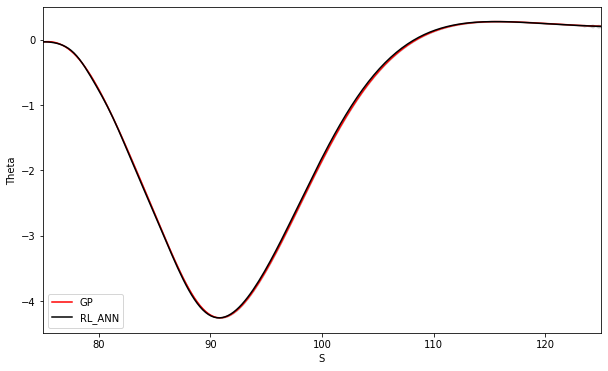

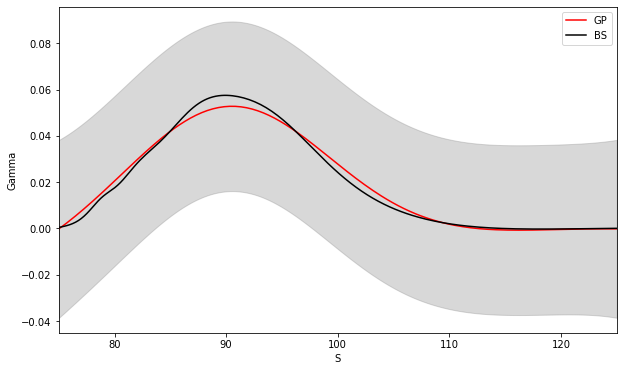

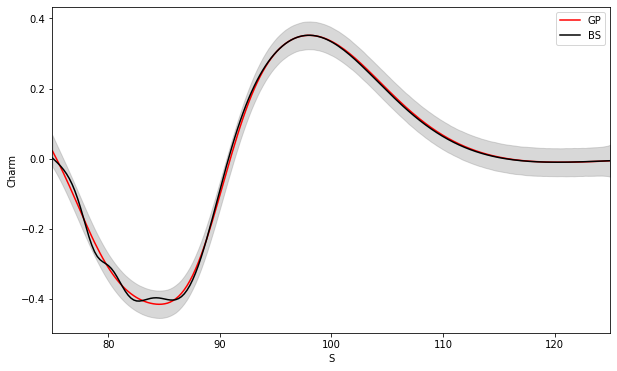

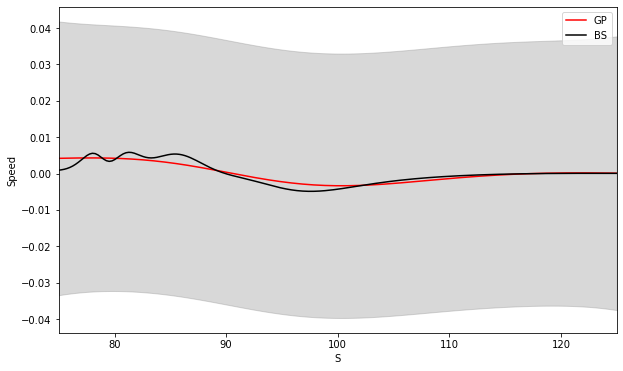

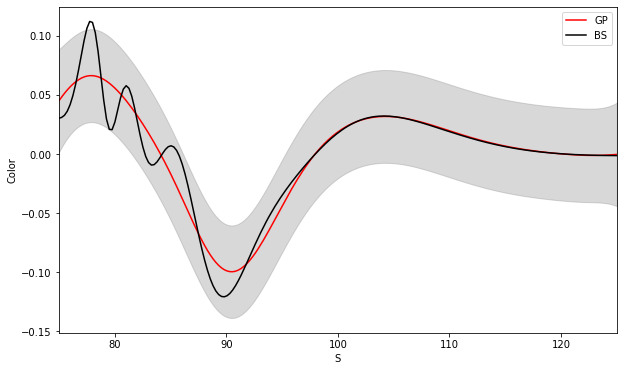

In [ ]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,0]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,0]), color = 'black', label = 'RL_ANN')
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,0].detach().numpy(), upper[:,0].detach().numpy(), color = 'grey', alpha=0.5)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('C')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,1]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y2), color = 'black', label = 'RL_ANN')
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,1].detach().numpy(), upper[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('Delta')

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,2]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y3), color = 'black', label = 'RL_ANN')
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,2].detach().numpy(), upper[:,2].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('Theta')

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,3]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y4), color = 'black', label = 'BS')
# plt.scatter(lb+(ub-lb)*train_x, train_y[:,3], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,3].detach().numpy(), upper[:,3].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('Gamma')

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,4]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y5), color = 'black', label = 'BS')
# plt.scatter(lb+(ub-lb)*train_x, train_y[:,4], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,4].detach().numpy(), upper[:,4].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('Charm')

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,5]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y6), color = 'black', label = 'BS')
# plt.scatter(lb+(ub-lb)*train_x, train_y[:,5], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,5].detach().numpy(), upper[:,5].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('Speed')

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,6]), color = 'red', label = 'GP')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y7), color = 'black', label = 'BS')
# plt.scatter(lb+(ub-lb)*train_x, train_y[:,6], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,6].detach().numpy(), upper[:,6].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([75,125])
plt.xlabel('S')
plt.ylabel('Color')

## **1.4: MGPR + RL_ANN Solver**

## **1.5: Portfolio of Options**

# **Section 2: Basket European Option**

## **2.1: RL_ANN Solver**

### **2.1.1: European Call**

START TRAINING
Epoch: 0 Loss: 0.10500043630599976
Epoch: 1 Loss: 0.10389173775911331
Epoch: 2 Loss: 0.10371042788028717
Epoch: 3 Loss: 0.10364247113466263
Epoch: 4 Loss: 0.1035754606127739
Epoch: 5 Loss: 0.10342611372470856
Epoch: 6 Loss: 0.10289844870567322
Epoch: 7 Loss: 0.10051047056913376
Epoch: 8 Loss: 0.0032711655367165804
Epoch: 9 Loss: 0.0009208990959450603
Epoch: 10 Loss: 0.0008918354869820178
Epoch: 11 Loss: 0.0007854625000618398
Epoch: 12 Loss: 0.0004884465015493333
Epoch: 13 Loss: 0.0001765624328982085
Epoch: 14 Loss: 0.00011691782128764316
Epoch: 15 Loss: 0.001207098481245339
Epoch: 16 Loss: 9.289144509239122e-05
Epoch: 17 Loss: 9.971528925234452e-05
Epoch: 18 Loss: 4.229095429764129e-05
Epoch: 19 Loss: 0.00029014848405495286
Epoch: 20 Loss: 3.6708781408378854e-05
Epoch: 21 Loss: 2.9031751182628796e-05
Epoch: 22 Loss: 4.269999772077426e-05
Epoch: 23 Loss: 1.6922069335123524e-05
Epoch: 24 Loss: 3.990676486864686e-05
Epoch: 25 Loss: 6.991122791077942e-05
Epoch: 26 Loss: 1.33

No handles with labels found to put in legend.


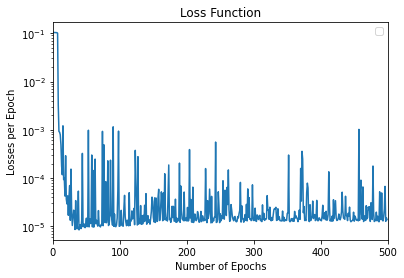

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

np.random.seed(99999)
tf.random.set_seed(99999)

tf.keras.backend.set_floatx('float64')

directory = '.'

# network for synthetic data
activation = tf.tanh
hidden_layer = [50,50,50]
n_outputs = 1
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 100000, decay_rate=0.96, staircase=False, name=None)

#input processing
def process_input(X_input, X_input_):
	r = tf.fill([tf.shape(input=X_input)[0],1], np.float64(0.), name = 'r') # interest rate, if applicable

	S = tf.slice(X_input, (0,0), (-1,1))
	K = tf.slice(X_input, (0,1), (-1,1))
	T = tf.slice(X_input, (0,2), (-1,1))
	
	S_ = tf.slice(X_input_, (0,0), (-1,1))
	T_ = tf.slice(X_input_, (0,1), (-1,1))
	return S, K, T, S_, T_, r

# define neural network architecture
ann = tf.keras.Sequential(
    layers=[tf.keras.layers.Dense(hidden_layer[0], activation = activation, input_shape = (2,))] + \
	[tf.keras.layers.Dense(hidden_layer[i], activation = activation) for i in range(1, len(hidden_layer))] + \
	[tf.keras.layers.Dense(n_outputs, activation = tf.keras.activations.softplus)],
    name="ann")

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# define loss function
hedging_mse = tf.keras.losses.MeanSquaredError()

#evaluate loss function and gradient
@tf.function
def loss(X_input, X_input_):
  S, K, T, S_, T_, r = process_input(X_input, X_input_)
  with tf.GradientTape() as tape:
        tape.watch(S)
        X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN
        X_ = tf.concat([S_/(K*tf.exp(-r*T_)), T_], 1) #input matrix for ANN_

        out = ann(X)
        out = K*tf.where(tf.greater(T, 1e-3), out, tf.maximum(S/K - 1, 0))
        out_ = ann(X_)
        out_ = K*tf.where(tf.greater(T_, 1e-3), out_, tf.maximum(S_/K - 1, 0))

  delta = tape.gradient(out, S)
  return hedging_mse(delta*(S_-S), out_-out)

@tf.function
def grad(X_train, X_train_):
	with tf.GradientTape() as tape:
		tape.watch(ann.trainable_variables)
		loss_value = loss(X_train, X_train_)
	return loss_value, tape.gradient(loss_value, ann.trainable_variables)

# define training ops
@tf.function
def training_op(X_train, X_train_):
	loss_value, grads = grad(X_train, X_train_)
	optimizer.apply_gradients(zip(grads, ann.trainable_variables))

# Simulating geometric Brownian motion
def stock_sim_path(S, alpha, delta, sigma, T, N, n):
    """Simulates geometric Brownian motion."""
    h = T/n
    mean = (alpha - delta - .5*sigma**2)*h
    vol = sigma * h**.5
    return S*np.exp((mean + vol*np.random.randn(n,N)).cumsum(axis = 0))

def get_batch2(stock_paths,n, moneyness_range = (.5,2)): 
    """Constructs theoretical options based on the time series stock_paths"""
    S_total = []
    S_total_ = []
    K_total = []
    picks = np.random.randint(0, len(stock_paths[0])-1, n)
    for stock_path in stock_paths:
      S = stock_path[picks]
      S_ = stock_path[picks+1]
      K = np.random.uniform(*moneyness_range, (n,1))*S
      S_total.append(S)
      S_total_.append(S_)
      K_total.append(K)
    S = sum(S_total)/len(S_total)
    S_ = sum(S_total_)/len(S_total_)
    K = sum(K_total)/len(K_total)
    T = np.random.randint(1, 150, (n,1))
    X = np.hstack([S, K, T/250])
    X_ = np.hstack([S_, (T-1)/250])
    return X, X_

#model training
n_epochs = 500  # number of training epochs
n_batches = 1000  # number of batches per epoch
batch_size = 10000 # number of theoretical options in each batch
T = 2 # number of years of training data
days = int(250*T)

n_basket_underlyings = 5
stock_paths = []
stock_paths_test = []
for i in range(n_basket_underlyings):
  stock_paths.append(stock_sim_path(100, .058, 0, .125, T, 1, days))
  stock_paths_test.append(stock_sim_path(100, .058, 0, .125, T, 1, days))

# stock_path = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path
# stock_path_test = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path
# stock_path_test = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path used in original paper
# stock_path_test = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path for cross-validation used in original paper

X_test, X_test_ = get_batch2(stock_paths_test, batch_size) #get test-set

# #TRAINING
losses = []
count = 0
print("START TRAINING")
for epoch in range(n_epochs):
	for batch in range(n_batches):
		X_train, X_train_ = get_batch2(stock_paths, batch_size) # get batch of theoretical options
		training_op(X_train, X_train_)
	epoch_loss = loss(X_test, X_test_)
	losses.append(epoch_loss)
	print('Epoch:', epoch, 'Loss:', epoch_loss.numpy())
	count += 1
ann.save('gbm_basket_european_call.h5')

plt.figure()
plt.semilogy(np.arange(count), losses)
plt.legend()
plt.title('Loss Function')
plt.xlabel('Number of Epochs')
plt.ylabel('Losses per Epoch')
plt.xlim([0, count])
plt.savefig('gbm_basket_european_call_loss.png')

In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as si
from scipy.stats import gmean

def bs(S, K, T, r, sigma):
	F = gmean([S, S, S, S, S])
	d1 = (np.log(F / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
	d2 = (np.log(F / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
	
	call = (F * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
	delta = np.exp(-r * T) * si.norm.pdf(d2) / (S * sigma * np.sqrt(T))
	theta = - (S * sigma * si.norm.pdf(d1)) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)
	gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T)) 
	charm = - si.norm.pdf(d1) * (2*r*T - d2*sigma*np.sqrt(T)) / (2 * T * sigma * np.sqrt(T))
	speed = - gamma/S * (d1/(sigma * np.sqrt(T))+1)
	color = - (si.norm.pdf(d1)/(2*S*T*sigma*np.sqrt(T)))*(1+((2*r*T - d2*sigma*np.sqrt(T))/(2*T*sigma*np.sqrt(T))))
	return call, delta, theta, gamma, charm, speed, color

if not os.path.isdir('results'):
    os.makedirs('results')

model = tf.keras.models.load_model('gbm_basket_european_call.h5')
print("Model restored.")
model.summary()

#Initialize time list
t = []
for i in range(60,121,10):
	t.append(i/250)

# 3-D cost graph, for various K & T, K is ranging from (90,110), while T ranges from (60,120,10)
for j in range(len(t)):
	T = t[j]
	print("Time to Maturity: ", T)
	K = []
	for i in range(21):
		K.append(i+90)

	if not os.path.isdir('results/TTM: ' + str(T)):
			os.makedirs('results/TTM: ' + str(T))

	X_train = np.ones((10000,3,21))
	for i in range(21):
		X_train[:, 0, i] = np.linspace(75, 125, num=10000)
		X_train[:, 1, i] *= K[i]
		X_train[:, 2, i] *= T
	bs_call = np.ones((10000,21))
	bs_delta = np.ones((10000,21))
	bs_theta = np.ones((10000,21))
	bs_gamma = np.ones((10000,21))
	bs_charm = np.ones((10000,21))
	bs_speed = np.ones((10000,21))
	bs_color = np.ones((10000,21))

	for i in range(21):
		call, delta, theta, gamma, charm, speed, color = bs(X_train[:,0,i], K[i], T, 0.1, .125)
		bs_call[:,i] = call
		bs_delta[:,i] = delta
		bs_theta[:,i] = theta
		bs_gamma[:,i] = gamma
		bs_charm[:,i] = charm
		bs_speed[:,i] = speed
		bs_color[:,i] = color
	pred_call = np.ones((10000,21))
	pred_delta = np.ones((10000,21))
	pred_theta = np.ones((10000,21))
	pred_gamma = np.ones((10000,21))
	pred_charm = np.ones((10000,21))
	pred_speed = np.ones((10000,21))
	pred_color = np.ones((10000,21))

	# Evaluation	
	for i in range(21):
		r = tf.fill([tf.shape(input=X_train)[0],1], np.float64(0.1), name = 'r') # interest rate, if applicable
		S = tf.slice(X_train[:,:,i], (0,0), (-1,1))
		K = tf.slice(X_train[:,:,i], (0,1), (-1,1))
		T = tf.slice(X_train[:,:,i], (0,2), (-1,1))
		with tf.GradientTape() as tape0:
			tape0.watch([S,T])
			with tf.GradientTape() as tape1:
				tape1.watch([S,T])
				with tf.GradientTape() as tape2:
						tape2.watch([S,T])
						X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN

						out = model(X)
						out_values = (K)*tf.where(tf.greater(T, 1e-3), out, tf.maximum(S/K - 1, 0))
				delta_values, theta_values = tape2.gradient(out_values, [S,T])
			gamma_values, charm_values = tape1.gradient(delta_values, [S,T])
		speed_values, color_values = tape0.gradient(gamma_values, [S,T])

		out_values = out_values.numpy()
		delta_values = delta_values.numpy()
		theta_values = - theta_values
		theta_values = theta_values.numpy()
		gamma_values = gamma_values.numpy()
		charm_values = - charm_values
		charm_values = charm_values.numpy()
		speed_values = speed_values.numpy()
		color_values = color_values.numpy()
		pred_call[:,i] = out_values.reshape(10000,)
		pred_delta[:,i] = delta_values.reshape(10000,)
		pred_theta[:,i] = theta_values.reshape(10000,)
		pred_gamma[:,i] = gamma_values.reshape(10000,)
		pred_charm[:,i] = charm_values.reshape(10000,)
		pred_speed[:,i] = speed_values.reshape(10000,)
		pred_color[:,i] = color_values.reshape(10000,)
		
	stock_price= X_train[:, 0, :].reshape(10000,21)
	strike_price= X_train[:, 1, :].reshape(10000,21)

	# Results
	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('C')
	ax.legend(loc = 'best', prop={'size':10})

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_call, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_call, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('C')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Price.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_delta, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_delta, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Delta')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Delta.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_theta, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_theta, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Theta')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Theta.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_gamma, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_gamma, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Gamma')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_charm, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_charm, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Charm')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Charm.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_speed, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_speed, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Speed')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Speed.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_color, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_color, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Color')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Color.png')
 
	# # Error of Results
	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_call-pred_call, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Call Price')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_delta-pred_delta, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Delta Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Delta_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_theta-pred_theta, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Theta Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Theta_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_gamma-pred_gamma, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Gamma Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_charm-pred_charm, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Charm Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Charm_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_speed-pred_speed, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Speed Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Speed_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_color-pred_color, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Color Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Color_Error.png')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

means = np.zeros(5)
corr_mat = np.matrix([[1, 0.1, -0.1, 0, 0], [0.1, 1, 0, 0, 0.2], [-0.1, 0, 1, 0, 0], [0, 0, 0, 1, 0.15], [0, 0.2, 0, 0.15, 1]])
vols = np.array([0.1, 0.12, 0.13, 0.09, 0.11])

cov_mat = np.diag(vols).dot(corr_mat).dot(np.diag(vols))

initial_spots = np.array([100., 100., 100., 100., 100.])
tte = 1.0
strike = 100
seed = 43
num_paths = 100000

results = []
rng = multivariate_normal(means, cov_mat).rvs(size=num_paths, random_state=seed)

for i in range(num_paths):
    rns = rng[i]
    final_spots = initial_spots * np.exp(-0.5*vols*vols*tte) * np.exp(tte * rns)
    results.append(final_spots)

df = pd.DataFrame(results)
df['payoff'] = ((df.sum(axis=1) / 5) - strike).clip(0)

df['payoff'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  import sys


2.0975012021340724

In [ ]:
asset_0_options = []
for each in df[0]:
  call = bs(each, 100, 1.0, 0, 0.1)[0]
  asset_0_options.append(call)
avg_0 = sum(asset_0_options)/50000

asset_1_options = []
for each in df[1]:
  call = bs(each, 100, 1.0, 0, 0.1)[0]
  asset_1_options.append(call)
avg_1 = sum(asset_1_options)/50000

asset_2_options = []
for each in df[2]:
  call = bs(each, 100, 1.0, 0, 0.1)[0]
  asset_2_options.append(call)
avg_2 = sum(asset_2_options)/50000

asset_3_options = []
for each in df[3]:
  call = bs(each, 100, 1.0, 0, 0.1)[0]
  asset_3_options.append(call)
avg_3 = sum(asset_3_options)/50000

asset_4_options = []
for each in df[4]:
  call = bs(each, 100, 1.0, 0, 0.1)[0]
  asset_4_options.append(call)
avg_4 = sum(asset_4_options)/50000
(avg_0 + avg_1 +avg_2+avg_3+avg_4)/5

5.934451999259591

# **Section 3: Exotic Options**

**Binary Call**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

np.random.seed(8889)
tf.random.set_seed(8889)

tf.keras.backend.set_floatx('float64')

directory = '.'

# network for synthetic data
activation = tf.tanh
hidden_layer = [50,50,50]
n_outputs = 1
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 100000, decay_rate=0.96, staircase=False, name=None)

#input processing
def process_input(X_input, X_input_):
  r = tf.fill([tf.shape(input=X_input)[0],1], np.float64(0.), name = 'r') # interest rate, if applicable
  S = tf.slice(X_input, (0,0), (-1,1))
  K = tf.slice(X_input, (0,1), (-1,1))
  T = tf.slice(X_input, (0,2), (-1,1))
  S_ = tf.slice(X_input_, (0,0), (-1,1))
  T_ = tf.slice(X_input_, (0,1), (-1,1))
  return S, K, T, S_, T_, r

# define neural network architecture
ann = tf.keras.Sequential(
    layers=[tf.keras.layers.Dense(hidden_layer[0], activation = activation, input_shape = (2,))] + \
	[tf.keras.layers.Dense(hidden_layer[i], activation = activation) for i in range(1, len(hidden_layer))] + \
	[tf.keras.layers.Dense(n_outputs, activation = tf.keras.activations.softplus)],
    name="ann")

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# define loss function
hedging_mse = tf.keras.losses.MeanSquaredError()

#evaluate loss function and gradient
@tf.function
def loss(X_input, X_input_):
  S, K, T, S_, T_, r = process_input(X_input, X_input_)
  with tf.GradientTape(persistent=True) as tape:
        tape.watch(S)
        X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN
        X_ = tf.concat([S_/(K*tf.exp(-r*T_)), T], 1) #input matrix for ANN_

        out = ann(X)
        # out = (K)*tf.where(tf.greater(T, 1e-3), out, tf.where(tf.greater(S, K), S/K, 0))
        out = K*tf.where(tf.greater(T, 1e-3), out, tf.maximum(S/K - 1, 0))
        out_ = ann(X_)
        out_ = K*tf.where(tf.greater(T_, 1e-3), out_, tf.maximum(S_/K - 1, 0))
  delta = tape.gradient(out, S)
  return hedging_mse(delta*(S_-S), out_-out)

@tf.function
def grad(X_train, X_train_):
	with tf.GradientTape() as tape:
		tape.watch(ann.trainable_variables)
		loss_value = loss(X_train, X_train_)
	return loss_value, tape.gradient(loss_value, ann.trainable_variables)

# define training ops
@tf.function
def training_op(X_train, X_train_):
	loss_value, grads = grad(X_train, X_train_)
	optimizer.apply_gradients(zip(grads, ann.trainable_variables))

# Simulating geometric Brownian motion
def stock_sim_path(S, alpha, delta, sigma, T, N, n):
    """Simulates geometric Brownian motion."""
    h = T/n
    mean = (alpha - delta - .5*sigma**2)*h
    vol = sigma * h**.5
    return S*np.exp((mean + vol*np.random.randn(n,N)).cumsum(axis = 0))

def get_batch2(stock_path,n, moneyness_range = (0.5,2)): 
    """Constructs theoretical options based on the time series stock_path"""
    picks = np.random.randint(0, len(stock_path)-1, n)
    T = np.random.randint(1, 150, (n,1))
    S = stock_path[picks]
    S_ = stock_path[picks+1]
    K = np.random.uniform(*moneyness_range, (n,1))*S
    X = np.hstack([S, K, T/250])
    X_ = np.hstack([S_, (T-1)/250])
    return X, X_

#model training
n_epochs = 500  # number of training epochs
n_batches = 1000  # number of batches per epoch
batch_size = 10000 # number of theoretical options in each batch
T = 2 # number of years of training data
days = int(250*T)

stock_path = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path
stock_path_test = stock_sim_path(100, .058, 0, .125, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path
# stock_path_test = stock_sim_path(100, .06386, 0, .07425, T, 1, days) #simulate stock path for cross-validation

# stock_path = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path used in original paper
# stock_path_test = stock_sim_path(100, .05, 0, .15, T, 1, days) #simulate stock path for cross-validation used in original paper

X_test, X_test_ = get_batch2(stock_path_test, batch_size) #get test-set

#TRAINING
losses = []
count = 0
print("START TRAINING")
for epoch in range(n_epochs):
	for batch in range(n_batches):
		X_train, X_train_ = get_batch2(stock_path, batch_size) # get batch of theoretical options
		training_op(X_train, X_train_)
	epoch_loss = loss(X_test, X_test_)
	losses.append(epoch_loss)
	print('Epoch:', epoch, 'Loss:', epoch_loss.numpy())
	count += 1
ann.save('gbm_single_european_call.h5')

plt.figure()
plt.semilogy(np.arange(count), losses)
plt.legend()
plt.title('Loss Function')
plt.xlabel('Number of Epochs')
plt.ylabel('Losses per Epoch')
plt.xlim([0, count])
plt.savefig('gbm_single_european_call_loss.png')

START TRAINING


NotImplementedError: ignored

In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as si

def bs(S, K, T, r, sigma):
	d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
	d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
	
	call = S * si.norm.cdf(d1)
	delta = np.exp(-r * T) * si.norm.pdf(d2) / (S * sigma * np.sqrt(T))
	theta = - (S * sigma * si.norm.pdf(d1)) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)
	gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T)) 
	charm = - si.norm.pdf(d1) * (2*r*T - d2*sigma*np.sqrt(T)) / (2 * T * sigma * np.sqrt(T))
	speed = - gamma/S * (d1/(sigma * np.sqrt(T))+1)
	color = - (si.norm.pdf(d1)/(2*S*T*sigma*np.sqrt(T)))*(1+((2*r*T - d2*sigma*np.sqrt(T))/(2*T*sigma*np.sqrt(T))))
	return call, delta, theta, gamma, charm, speed, color

if not os.path.isdir('results'):
    os.makedirs('results')

model = tf.keras.models.load_model('gbm_single_european_call.h5')
print("Model restored.")
model.summary()

#Initialize time list
t = []
for i in range(60,121,10):
	t.append(i/250)

# 3-D cost graph, for various K & T, K is ranging from (90,110), while T ranges from (60,120,10)
for j in range(len(t)):
	T = t[j]
	print("Time to Maturity: ", T)
	K = []
	for i in range(21):
		K.append(i+90)

	if not os.path.isdir('results/TTM: ' + str(T)):
			os.makedirs('results/TTM: ' + str(T))

	X_train = np.ones((10000,3,21))
	for i in range(21):
		X_train[:, 0, i] = np.linspace(75, 125, num=10000)
		X_train[:, 1, i] *= K[i]
		X_train[:, 2, i] *= T
	bs_call = np.ones((10000,21))
	bs_delta = np.ones((10000,21))
	bs_theta = np.ones((10000,21))
	bs_gamma = np.ones((10000,21))
	bs_charm = np.ones((10000,21))
	bs_speed = np.ones((10000,21))
	bs_color = np.ones((10000,21))

	for i in range(21):
		call, delta, theta, gamma, charm, speed, color = bs(X_train[:,0,i], K[i], T, 0.1, .125)
		bs_call[:,i] = call
		bs_delta[:,i] = delta
		bs_theta[:,i] = theta
		bs_gamma[:,i] = gamma
		bs_charm[:,i] = charm
		bs_speed[:,i] = speed
		bs_color[:,i] = color
	pred_call = np.ones((10000,21))
	pred_delta = np.ones((10000,21))
	pred_theta = np.ones((10000,21))
	pred_gamma = np.ones((10000,21))
	pred_charm = np.ones((10000,21))
	pred_speed = np.ones((10000,21))
	pred_color = np.ones((10000,21))

	# Evaluation	
	for i in range(21):
		r = tf.fill([tf.shape(input=X_train)[0],1], np.float64(0.1), name = 'r') # interest rate, if applicable
		S = tf.slice(X_train[:,:,i], (0,0), (-1,1))
		K = tf.slice(X_train[:,:,i], (0,1), (-1,1))
		T = tf.slice(X_train[:,:,i], (0,2), (-1,1))
		with tf.GradientTape() as tape0:
			tape0.watch([S,T])
			with tf.GradientTape() as tape1:
				tape1.watch([S,T])
				with tf.GradientTape() as tape2:
						tape2.watch([S,T])
						X = tf.concat([S/(K*tf.exp(-r*T)), T], 1) #input matrix for ANN

						out = model(X)
						out_values = (K)*tf.where(tf.greater(T, 1e-3), out, tf.where(tf.greater(S, K), S/K, 0))
				delta_values, theta_values = tape2.gradient(out_values, [S,T])
			gamma_values, charm_values = tape1.gradient(delta_values, [S,T])
		speed_values, color_values = tape0.gradient(gamma_values, [S,T])

		out_values = out_values.numpy()
		delta_values = delta_values.numpy()
		theta_values = - theta_values
		theta_values = theta_values.numpy()
		gamma_values = gamma_values.numpy()
		charm_values = - charm_values
		charm_values = charm_values.numpy()
		speed_values = speed_values.numpy()
		color_values = color_values.numpy()
		pred_call[:,i] = out_values.reshape(10000,)
		pred_delta[:,i] = delta_values.reshape(10000,)
		pred_theta[:,i] = theta_values.reshape(10000,)
		pred_gamma[:,i] = gamma_values.reshape(10000,)
		pred_charm[:,i] = charm_values.reshape(10000,)
		pred_speed[:,i] = speed_values.reshape(10000,)
		pred_color[:,i] = color_values.reshape(10000,)
		
	stock_price= X_train[:, 0, :].reshape(10000,21)
	strike_price= X_train[:, 1, :].reshape(10000,21)

	# Results
	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('C')
	ax.legend(loc = 'best', prop={'size':10})

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, pred_call, color='red', label='RL_ANN' )
	ax.plot_wireframe(stock_price, strike_price, bs_call, color='green', label = 'BS')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('C')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Price.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_delta, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_delta, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Delta')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Delta.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_theta, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_theta, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Theta')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Theta.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_gamma, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_gamma, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Gamma')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_charm, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_charm, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Charm')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Charm.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_speed, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_speed, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Speed')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Speed.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, pred_color, color='red', label='RL_ANN' )
	# ax.plot_wireframe(stock_price, strike_price, bs_color, color='green', label = 'BS')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Color')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Color.png')
 
	# # Error of Results
	plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	plt.rcParams['axes.facecolor'] = 'white'
	ax = plt.axes(projection='3d')

	angle = 225
	ax.view_init(37.5, angle)
	ax.plot_wireframe(stock_price, strike_price, bs_call-pred_call, color='black', label = 'Error')
	ax.set_xlabel('S')
	ax.set_ylabel('K')
	ax.set_zlabel('Error of Call Price')
	ax.legend(loc = 'best', prop={'size':10})
	plt.show()
	plt.savefig('results/TTM: ' + str(t[j]) + '/Call_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_delta-pred_delta, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Delta Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Delta_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_theta-pred_theta, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Theta Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Theta_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_gamma-pred_gamma, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Gamma Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Gamma_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_charm-pred_charm, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Charm Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Charm_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_speed-pred_speed, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Speed Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Speed_Error.png')

	# plt.figure(figsize = (12, 9), facecolor='white', edgecolor='black')
	# plt.rcParams['axes.facecolor'] = 'white'
	# ax = plt.axes(projection='3d')

	# angle = 225
	# ax.view_init(37.5, angle)
	# ax.plot_wireframe(stock_price, strike_price, bs_color-pred_color, color='black', label = 'Error')
	# ax.set_xlabel('S')
	# ax.set_ylabel('K')
	# ax.set_zlabel('Error of Color Value')
	# ax.legend(loc = 'best', prop={'size':10})
	# plt.show()
	# plt.savefig('results/TTM: ' + str(t[j]) + '/Color_Error.png')

OSError: ignored